In [1]:
import os
import re
from itertools import chain
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModel, AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import optuna

In [2]:
class Seq2SeqDataset(Dataset):
    def __init__(self, dataset, bert_tokenizer, gpt_tokenizer, bert_device, gpt_device):
        super(Seq2SeqDataset, self).__init__()
        
        self.bert_tokenizer = bert_tokenizer
        self.gpt_tokenizer = gpt_tokenizer
        self.bert_device = bert_device
        self.gpt_device = gpt_device
        
        self.sent1, self.sent2 = self.create_pair_dataset(dataset)
        
    def __getitem__(self, i):
        bert_sent1 = self.bert_tokenizer(self.sent1[i], padding='max_length', truncation=True, return_tensors='pt')
        gpt_sent2 = self.gpt_tokenizer(self.sent2[i], padding='max_length', truncation=True, return_tensors='pt')
        
        bert_sent1 = {k: v.squeeze().to(self.bert_device) for k, v in bert_sent1.items()}
        gpt_sent2 = {k: v.squeeze().to(self.gpt_device) for k, v in gpt_sent2.items()}
        
        return bert_sent1, gpt_sent2
    
    def __len__(self):
        return len(self.sent1)
    
    def create_tokenized_pairs(self, x):
        sentences = re.split(r'[\s]*#Person\d#: ', x['dialogue'])[1:]

        sentences1 = sentences[:-1]
        sentences2 = list(map(lambda x: self.gpt_tokenizer.bos_token + x + self.gpt_tokenizer.eos_token, sentences[1:]))

        return {'sent1': sentences1, 'sent2': sentences2}
    
    def create_pair_dataset(self, dataset):
        tokenized_dataset = dataset.map(self.create_tokenized_pairs)

        flatten_sent1 = [sent for sents in tokenized_dataset['sent1'] for sent in sents]
        flatten_sent2 = [sent for sents in tokenized_dataset['sent2'] for sent in sents]

        return flatten_sent1, flatten_sent2


In [3]:
def get_bert_model_tokenizer(path, model_max_length, bert_device):
    tokenizer = AutoTokenizer.from_pretrained(path, model_max_length=model_max_length)
    model = AutoModel.from_pretrained(path)
    
    return model.to(bert_device), tokenizer


def get_gpt_model_tokenizer(path, model_max_length, gpt_device):
    special_tokens = {'bos_token': '<BOS>', 'eos_token': '<EOS>', 
                      'unk_token': '<UNK>', 'pad_token': '<PAD>'}
    
    tokenizer = AutoTokenizer.from_pretrained(path, model_max_length=model_max_length)
    tokenizer.add_special_tokens(special_tokens)
    
    model = AutoModelForCausalLM.from_pretrained(path, add_cross_attention=True)
    model.resize_token_embeddings(len(tokenizer))
    model.config.add_cross_attention = True
    model.config.is_decoder = True
    
    return model.to(gpt_device), tokenizer


In [4]:
def get_dataloader(bs, bert_tokenizer, gpt_tokenizer, bert_device, gpt_device):
    train_data = load_dataset('knkarthick/dialogsum', split='train')
    val_data = load_dataset('knkarthick/dialogsum', split='validation')

    train_dataset = Seq2SeqDataset(train_data, bert_tokenizer, gpt_tokenizer, bert_device, gpt_device)
    val_dataset = Seq2SeqDataset(val_data, bert_tokenizer, gpt_tokenizer, bert_device, gpt_device)
    
    train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
    
    return train_dataloader, val_dataloader

In [5]:
class Seq2SeqModel:
    def __init__(self, bert_model, gpt_model, bert_tokenizer, gpt_tokenizer):
        self.bert_model = bert_model
        self.gpt_model = gpt_model
        self.bert_tokenizer = bert_tokenizer
        self.gpt_tokenizer = gpt_tokenizer
        
    def train_step(self, dataloader, optimizer):
        self.bert_model.train(), self.gpt_model.train()
        losses = []

        pbar = tqdm(dataloader)
        for i, (x, y) in enumerate(pbar):
            optimizer.zero_grad()
            bert_out = self.bert_model(**x)
            gpt_out = self.gpt_model(**y, labels=y['input_ids'], 
                                     encoder_hidden_states=bert_out.last_hidden_state.to(self.gpt_model.device))
            loss = gpt_out.loss
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            pbar.set_description(f'Batch Loss: {np.mean(losses):.5f}')
        
        return np.mean(losses)
        
    def eval_step(self, dataloader):
        self.bert_model.eval(), self.gpt_model.eval()
        losses = []

        pbar = tqdm(dataloader)
        for i, (x, y) in enumerate(pbar):
            bert_out = self.bert_model(**x)
            gpt_out = self.gpt_model(**y, labels=y['input_ids'], 
                                     encoder_hidden_states=bert_out.last_hidden_state.to(self.gpt_model.device))
            loss = gpt_out.loss

            losses.append(loss.item())
            pbar.set_description(f'Batch Loss: {np.mean(losses):.5f}')
        
        return np.mean(losses)
    
    def answer(self, sent):
        with torch.no_grad():
            tokenized_sent = self.bert_tokenizer(sent, padding='max_length', 
                                                 truncation=True, return_tensors='pt')
            tokenized_ans = self.gpt_tokenizer(self.gpt_tokenizer.bos_token, return_tensors='pt')

            tokenized_sent = {k: v.to(self.bert_model.device) for k, v in tokenized_sent.items()}
            tokenized_ans = {k: v.to(self.gpt_model.device) for k, v in tokenized_ans.items()}
            
            bert_out = self.bert_model(**tokenized_sent)
            gpt_out = self.gpt_model.generate(**tokenized_ans, max_new_tokens=30, temperature=0.9, 
                                              encoder_hidden_state=bert_out.last_hidden_state)

            return self.gpt_tokenizer.decode(gpt_out[0])

    def save(self, model_dir):
        os.makedirs(model_dir, exist_ok=True)
        self.bert_model.save_pretrained(os.path.join(model_dir, 'bert_encoder'))
        self.gpt_model.save_pretrained(os.path.join(model_dir, 'gpt_decoder'))
        

In [7]:
def train(max_len, epochs, bs, lr, bert_device, gpt_device, model_path):
    bert_encoder, bert_tokenizer = get_bert_model_tokenizer('bert-base-cased', max_len, bert_device)
    gpt_decoder, gpt_tokenizer = get_gpt_model_tokenizer('gpt2', max_len, gpt_device)

    train_loader, val_loader = get_dataloader(bs, bert_tokenizer, gpt_tokenizer, bert_device, gpt_device)
    opt = optim.Adam(chain(gpt_decoder.parameters(), bert_encoder.parameters()), lr=lr)

    seq2seq_model = Seq2SeqModel(bert_encoder, gpt_decoder, bert_tokenizer, gpt_tokenizer)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    train_losses, val_losses = [], []
    for e in range(epochs):
        train_loss = seq2seq_model.train_step(train_loader, opt)
        val_loss = seq2seq_model.eval_step(val_loader)
        
        clear_output(wait=True)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
                
        plt.plot(train_losses, 'b', label='Training losses')
        plt.plot(val_losses, 'r', label='Validation losses')
        plt.show()
        
        seq2seq_model.save(f'{model_path}_{val_loss}')
        
    plt.legend()

    
    #return val_loss


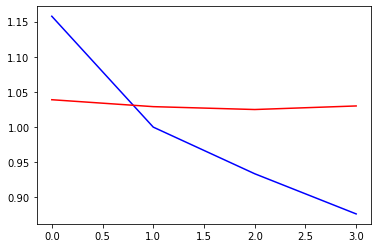

  0%|          | 0/35280 [00:00<?, ?it/s]

In [ ]:
train(max_len=50, bert_device=torch.device('cuda:0'), gpt_device=torch.device('cuda:1'), 
      model_path=f'epoch_loss', bs=3, lr=2.545263049508698e-05, epochs=10)

In [ ]:
whi

In [3]:
! zip -r bert_gpt.zip /kaggle/working/epoch_loss_1.0249150006171202

  adding: kaggle/working/epoch_loss_1.0249150006171202/ (stored 0%)
  adding: kaggle/working/epoch_loss_1.0249150006171202/gpt_decoder/ (stored 0%)
  adding: kaggle/working/epoch_loss_1.0249150006171202/gpt_decoder/config.json (deflated 52%)
  adding: kaggle/working/epoch_loss_1.0249150006171202/gpt_decoder/pytorch_model.bin (deflated 11%)
  adding: kaggle/working/epoch_loss_1.0249150006171202/bert_encoder/ (stored 0%)
  adding: kaggle/working/epoch_loss_1.0249150006171202/bert_encoder/config.json (deflated 48%)
  adding: kaggle/working/epoch_loss_1.0249150006171202/bert_encoder/pytorch_model.bin (deflated 7%)


In [7]:
def objective(trial):
    params = {'bs': trial.suggest_int('bs', 2, 6),
              'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True)}    
    
    return train(max_len=50, bert_device=torch.device('cuda:0'), 
                 gpt_device=torch.device('cuda:1'), model_path=f'trial{trial.number}', **params)


In [12]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=6)
print(study.best_params)


[I 2022-12-19 10:54:43,561] A new study created in memory with name: no-name-a98f1eea-e4d5-418f-ab3f-4fe285a8a39c
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2LMHeadModel were not in

  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/26460 [00:00<?, ?it/s]

  0%|          | 0/1048 [00:00<?, ?it/s]

[I 2022-12-19 12:04:52,292] Trial 0 finished with value: 1.081597953366528 and parameters: {'bs': 4, 'lr': 0.00021735438243198512}. Best is trial 0 with value: 1.081597953366528.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/26460 [00:00<?, ?it/s]

  0%|          | 0/1048 [00:00<?, ?it/s]

[I 2022-12-19 13:14:31,988] Trial 1 finished with value: 1.3879430635000458 and parameters: {'bs': 4, 'lr': 0.0009823185580343666}. Best is trial 0 with value: 1.081597953366528.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/17640 [00:00<?, ?it/s]

  0%|          | 0/699 [00:00<?, ?it/s]

[I 2022-12-19 14:08:32,026] Trial 2 finished with value: 1.4328137665603293 and parameters: {'bs': 6, 'lr': 0.0019448383663810552}. Best is trial 0 with value: 1.081597953366528.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/26460 [00:00<?, ?it/s]

  0%|          | 0/1048 [00:00<?, ?it/s]

[I 2022-12-19 15:18:19,919] Trial 3 finished with value: 1.4516949300433843 and parameters: {'bs': 4, 'lr': 0.001055327980234386}. Best is trial 0 with value: 1.081597953366528.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceCl

  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/35280 [00:00<?, ?it/s]

  0%|          | 0/1397 [00:00<?, ?it/s]

[I 2022-12-19 16:43:42,976] Trial 4 finished with value: 0.9833395414123727 and parameters: {'bs': 3, 'lr': 2.545263049508698e-05}. Best is trial 4 with value: 0.9833395414123727.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequence

  0%|          | 0/12460 [00:00<?, ?ex/s]

  0%|          | 0/500 [00:00<?, ?ex/s]

  0%|          | 0/35280 [00:00<?, ?it/s]

  0%|          | 0/1397 [00:00<?, ?it/s]

[I 2022-12-19 18:08:46,160] Trial 5 finished with value: 1.7344969805108708 and parameters: {'bs': 3, 'lr': 0.005516881543598113}. Best is trial 4 with value: 0.9833395414123727.


{'bs': 3, 'lr': 2.545263049508698e-05}


In [13]:
! zip -r bert_gpt.zip /kaggle/working/trial4_0.9833395414123727

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: kaggle/working/trial4_0.9833395414123727/ (stored 0%)
  adding: kaggle/working/trial4_0.9833395414123727/bert_encoder/ (stored 0%)
  adding: kaggle/working/trial4_0.9833395414123727/bert_encoder/pytorch_model.bin (deflated 7%)
  adding: kaggle/working/trial4_0.9833395414123727/bert_encoder/config.json (deflated 48%)
  adding: kaggle/working/trial4_0.9833395414123727/gpt_decoder/ (stored 0%)
  adding: kaggle/working/trial4_0.9833395414123727/gpt_decoder/pytorch_model.bin (deflated 11%)
  adding: kaggle/working/trial4_0.9833395414123727/gpt_decoder/config.json (deflated 52%)


In [ ]:
while True:
    pass